# Problem set 7: Solving the consumer problem with income risk

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Tasks

Solving the consumer problem is the **primary task** in this exercise set. You should spend most of the time you have on testing that you understand the different optimizers (problem I) and on solving the intertemporal consumption model (problem III). If for instance you are stuck in plotting, then skip ahead.   

## Optimization problem I

Consider the function

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) = (x_1^2 - x_1x_2 + x_2^2)^2
$$

Define it in **sympy** by:

In [2]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (x1**2 - x1*x2 + x2**2)**2

The **Jacobian** is

In [3]:
f1 = sm.diff(f,x1)
f2 = sm.diff(f,x2)
sm.Matrix([f1,f2])

Matrix([
[ (4*x_1 - 2*x_2)*(x_1**2 - x_1*x_2 + x_2**2)],
[(-2*x_1 + 4*x_2)*(x_1**2 - x_1*x_2 + x_2**2)]])

The **Hessian**  is

In [4]:
f11 = sm.diff(f,x1,x1)
f12 = sm.diff(f,x1,x2)
f21 = sm.diff(f,x2,x1)
f22 = sm.diff(f,x2,x2)
sm.Matrix([[f11,f12],[f21,f22]])

Matrix([
[      2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (2*x_1 - x_2)**2), 2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2))],
[2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2)),       2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (x_1 - 2*x_2)**2)]])

**Question A:** Lambdify $f(x_1,x_2)$ and use it to create: 

$(i)$ a 3D surfaceplot looking like this:

<img src="surfaceplot.png" 
     width="400" 
     height="500" />

$(ii)$ a contourplot looking like: 

<img src="contourplot.png" 
     width="400" 
     height="500" />

In [5]:
_f = sm.lambdify((x1,x2),f)

# write your code here
N = 500
xvec = np.linspace(-2, 2, N)
x1_mesh, x2_mesh = np.meshgrid(xvec, xvec, indexing='ij')
f_mesh = _f(x1_mesh, x2_mesh)

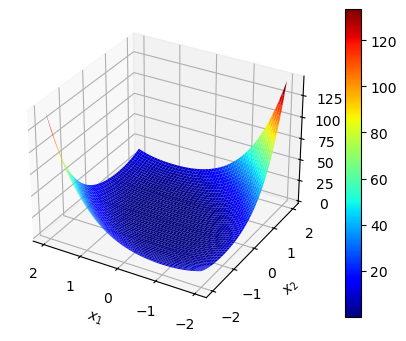

In [6]:
fig = plt.figure(dpi = 100, figsize=(7,4))
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_mesh,x2_mesh,f_mesh,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

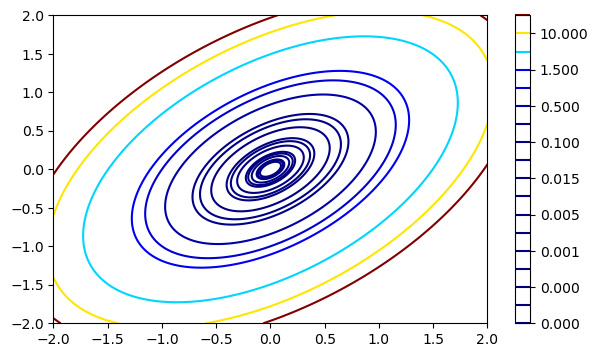

In [7]:
fig = plt.figure(dpi = 100, figsize=(7,4))
ax = fig.add_subplot(1,1,1)
levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
contour = ax.contour(x1_mesh,x2_mesh,f_mesh,levels=levels,cmap=cm.jet)
fig.colorbar(contour);


**Answer:** A1.py and A2.py

**Question B:** Construct python functions for the jacobian and the hessian.

In [8]:
f_python = lambda x: _f(x[0],x[1])

## jacobian
_jac1 = sm.lambdify((x1,x2),f1)
_jac2 = sm.lambdify((x1,x2), f2)
jac_python = lambda x: np.array([_jac1(x[0], x[1]), _jac2(x[0], x[1])])

## hessian
_hess11 = sm.lambdify((x1,x2), f11)
_hess12 = sm.lambdify((x1,x2), f12)
_hess21 = sm.lambdify((x1,x2), f21)
_hess22 = sm.lambdify((x1,x2), f22)
hess_python = lambda x: np.array([[_hess11(x[0], x[1]), _hess12(x[0], x[1])],
                                  [_hess21(x[0], x[1]), _hess22(x[0],x[1])]])

**Answer:** A3.py

**Question C:** Minimize $f(x_1,x_2)$ using respectively

1. Nelder-Mead,
2. BFGS without analytical jacobian,
3. BFGS with analytical jacobian, and
4. Newton-CG with analytical jacobian and hessian

Compare the results and discuss which optimizer you prefer.

**Optional:** If you wish, you can use the functions defined in the hidden cells below to also track how the optimizers converges to the solution.

In [9]:
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [f_python(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(f_python(x))
    
    # c. increment number of evaluations
    evals += 1

In [10]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
    cs = ax.contour(x1_mesh,x2_mesh,f_mesh,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

### Nelder-Mead

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.370486388165964e-18
             x: [ 5.430e-06  3.661e-05]
           nit: 43
          nfev: 83
 final_simplex: (array([[ 5.430e-06,  3.661e-05],
                       [-2.912e-05, -4.465e-05],
                       [-6.685e-05,  4.624e-06]]), array([ 1.370e-18,  2.376e-18,  2.303e-17]))


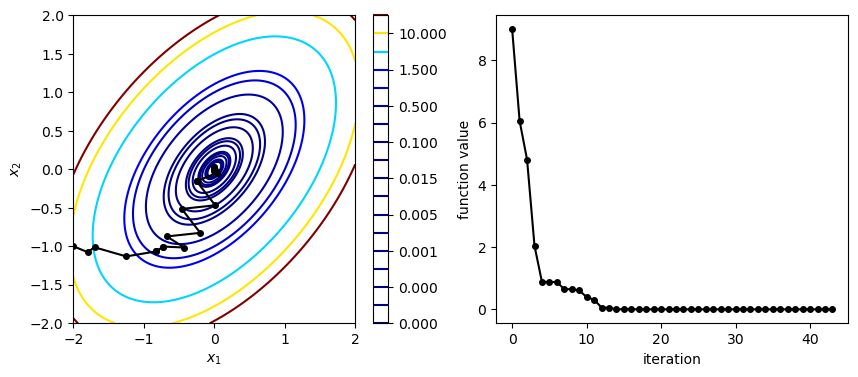

In [11]:
x0 = [-2,-1] # suggested initial guess
evals = 0

res_NM = optimize.minimize(f_python, x0=x0, method='nelder-mead', callback=collect) ## the callback function is called before each optimizer iteration
print(res_NM)
contour()

## Nelder-Mead found the minimum in 43 iterations with 83 (!) function evaluations. It also took a rather indirect path to the bottom - but it got there eventually!

### BFGS - no Jacobian

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.4155484553415043e-08
        x: [ 1.421e-02  5.136e-03]
      nit: 26
      jac: [ 7.240e-06 -1.225e-06]
 hess_inv: [[ 1.344e+02 -7.613e+01]
            [-7.613e+01  2.321e+02]]
     nfev: 84
     njev: 28


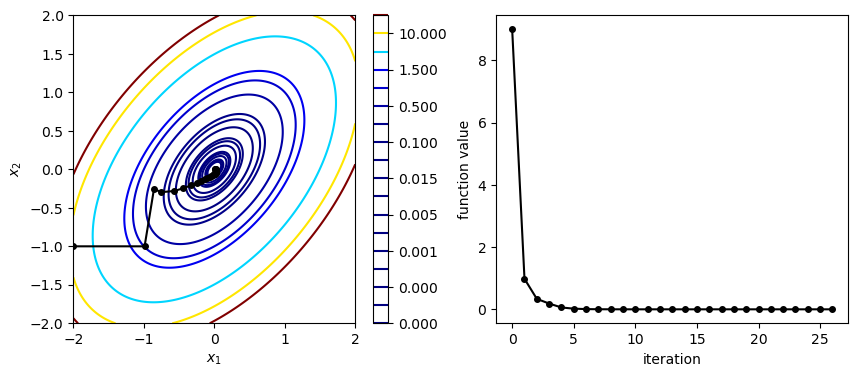

In [12]:
x0 = [-2,-1] # suggested initial guess
evals = 0

res_BFGS = optimize.minimize(f_python, x0=x0, method='bfgs', callback=collect)
print(res_BFGS)
contour()

## BFGS took a slightly more direct route and found the minimum in 26 iterations. However, it evaluated the objective function 84 times! 
## This is because BFGS needs a derivative, and if we don't provide it with one, it computes the numerical derivative - which requires additional function evaluations.

### BFGS - analytical Jacobian

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.4155899519593262e-08
        x: [ 1.421e-02  5.136e-03]
      nit: 26
      jac: [ 7.240e-06 -1.225e-06]
 hess_inv: [[ 1.344e+02 -7.613e+01]
            [-7.613e+01  2.321e+02]]
     nfev: 28
     njev: 28


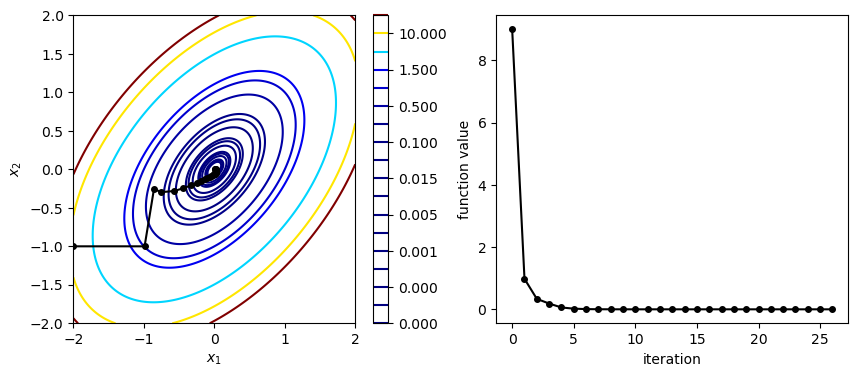

In [13]:
x0 = [-2,-1] # suggested initial guess
evals = 0

res_BFGSjac = optimize.minimize(f_python, x0=x0, jac=jac_python, method='bfgs', callback=collect)
print(res_BFGSjac)
contour()

## Now we provided the analytical Jacobian. The route taken was the same as before, and the number of iterations is the same, but now it only evaluated the objective function 28 times and the jacobian 28 times - so this one is faster.

### Newton-CG with Jacobian and Hessian

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.158963057079746e-09
       x: [-6.816e-03 -6.816e-03]
     nit: 15
     jac: [-6.335e-07 -6.335e-07]
    nfev: 15
    njev: 15
    nhev: 15


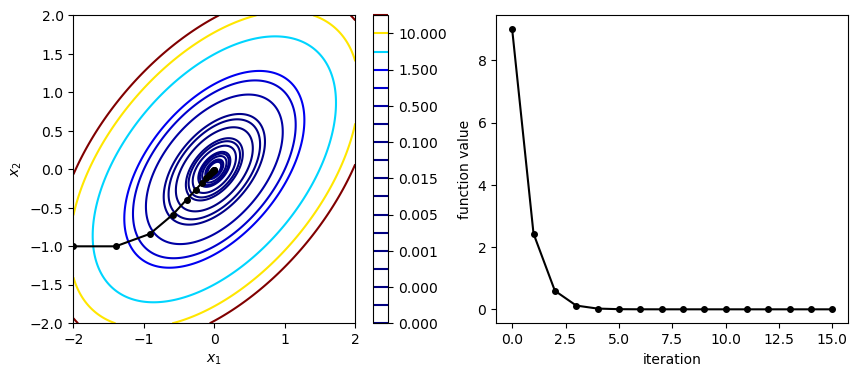

In [14]:
x0 = [-2,-1] # suggested initial guess
evals = 0

res_newton = optimize.minimize(f_python, x0=x0, jac=jac_python, hess=hess_python, method='newton-cg', callback=collect)
print(res_newton)
contour()

## Newton-CG is SUPER fast - only 15 iterations! But we can only use it if we know the Jacobian.

**Answer:** A4.py, A5.py, A6.py, A7.py

## Optimization problem II

Consider the function

$$
f(x_1,x_2) = (4-2.1x_1^2 + \frac{x_1^4}{3})x_1^2 + x_1x_2 + (4x_2^2 - 4)x_2^2)
$$

Define it in **sympy** by:

In [15]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
_f = sm.lambdify((x1,x2),f)
f

x_1**2*(x_1**4/3 - 2.1*x_1**2 + 4) + x_1*x_2 + x_2**2*(4*x_2**2 - 4)

Create **3D plot**:

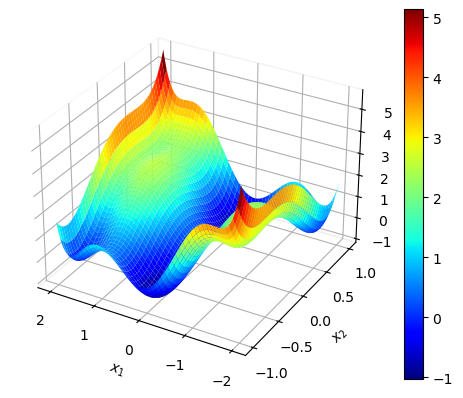

In [16]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-1,1,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Question A:** Find the minimum of the function starting from each of the suggested initial values below. Print the first 20 solutions, and all solutions aftwards, which is the best yet to be found. Save the solutions and associated function values in `xs` and `fs`.

In [17]:
# a. python function for f
f_python = lambda x: _f(x[0],x[1])

# b. initial guesses
np.random.seed(1986)
K = 1000
x0s = np.empty((K,2))
x0s[:,0] = -2 + 4*np.random.uniform(size=K)
x0s[:,1] = -1 + 2*np.random.uniform(size=K)

# c. solutions and associated values
xs = np.empty((K,2))
fs = np.empty(K)

f_best = np.inf
for i,x0 in enumerate(x0s):
    res = optimize.minimize(f_python, x0=x0, method='bfgs')
    assert res.success

    xs[i] = res.x
    fs[i] = res.fun

    if i < 20 or res.fun < f_best:
        print(f'iteration {i :<5}:   x0: ({x0[0] :5.2f}, {x0[1] : 5.2f})   x_opt: ({res.x[0] :5.2f}, {res.x[1] : 5.2f})    f: {res.fun :5.2f}')

    if res.fun < f_best:
        f_best = res.fun


iteration 0    :   x0: ( 0.28, -0.58)   x_opt: ( 0.09, -0.71)    f: -1.03
iteration 1    :   x0: (-1.69, -0.97)   x_opt: (-1.70,  0.80)    f: -0.22
iteration 2    :   x0: ( 0.43, -0.80)   x_opt: ( 0.09, -0.71)    f: -1.03
iteration 3    :   x0: ( 1.59,  0.70)   x_opt: ( 1.70, -0.80)    f: -0.22
iteration 4    :   x0: ( 0.18, -0.25)   x_opt: ( 0.09, -0.71)    f: -1.03
iteration 5    :   x0: ( 0.81,  0.51)   x_opt: (-0.09,  0.71)    f: -1.03
iteration 6    :   x0: (-0.46,  0.41)   x_opt: (-0.09,  0.71)    f: -1.03
iteration 7    :   x0: ( 0.61, -0.89)   x_opt: ( 0.09, -0.71)    f: -1.03
iteration 8    :   x0: ( 0.76,  0.66)   x_opt: (-0.09,  0.71)    f: -1.03
iteration 9    :   x0: ( 0.87,  0.53)   x_opt: (-0.09,  0.71)    f: -1.03
iteration 10   :   x0: ( 0.76,  0.14)   x_opt: (-0.09,  0.71)    f: -1.03
iteration 11   :   x0: ( 1.23,  0.11)   x_opt: ( 1.70, -0.80)    f: -0.22
iteration 12   :   x0: (-0.87, -0.16)   x_opt: ( 0.09, -0.71)    f: -1.03
iteration 13   :   x0: ( 1.03, -0.92) 

**Answer:** A8.py

**Question B:** Create a 3D scatter plot of where the optimizer converges, and color the dots by the associated function values.

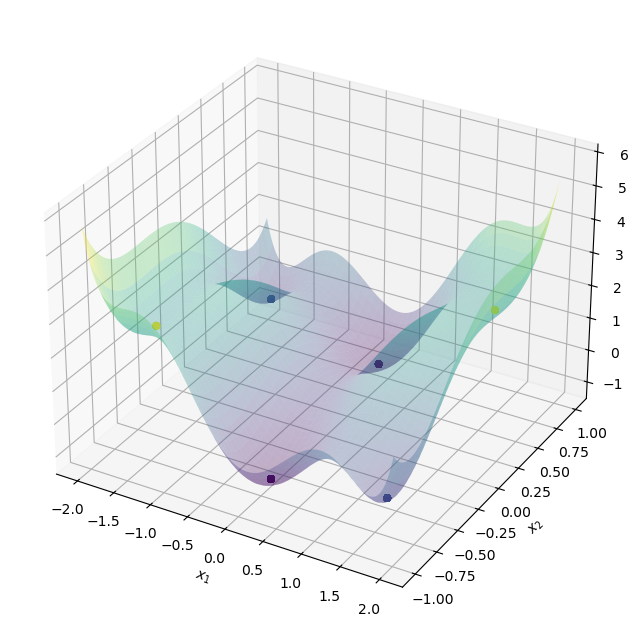

In [18]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs[:,0], xs[:,1], fs, c=fs)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('Found optimum value')

# add plot of objective function - we can se how we end up in multiple local minima
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,alpha=0.3, cmap='viridis')

**Answer:** A9.py

**Question C:** Plot the function values at the solutions as a function of the starting values.

Text(0.5, 0, 'Found optimum value')

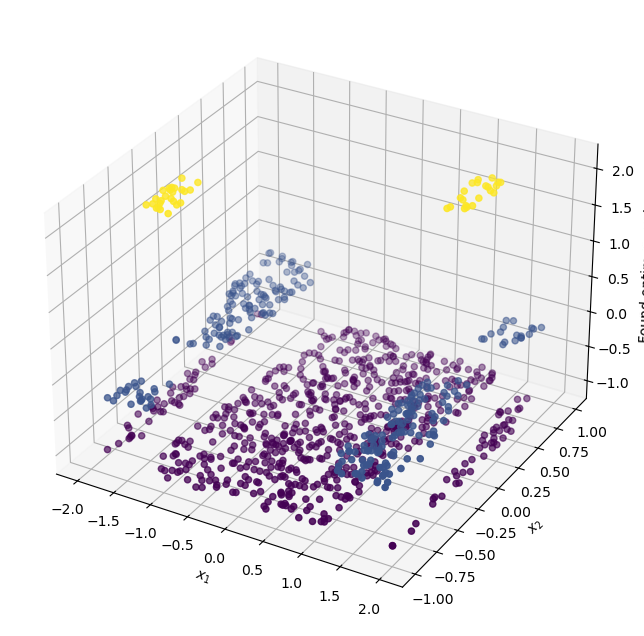

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x0s[:,0], x0s[:,1], fs, c=fs)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('Found optimum value')

**Answer:** A10.py

# Problem: Solve the consumer problem with income risk I

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

The **basic functions** are:

In [20]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

The **solution functions** are:

In [21]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x[0]
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec

**Question A:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it.

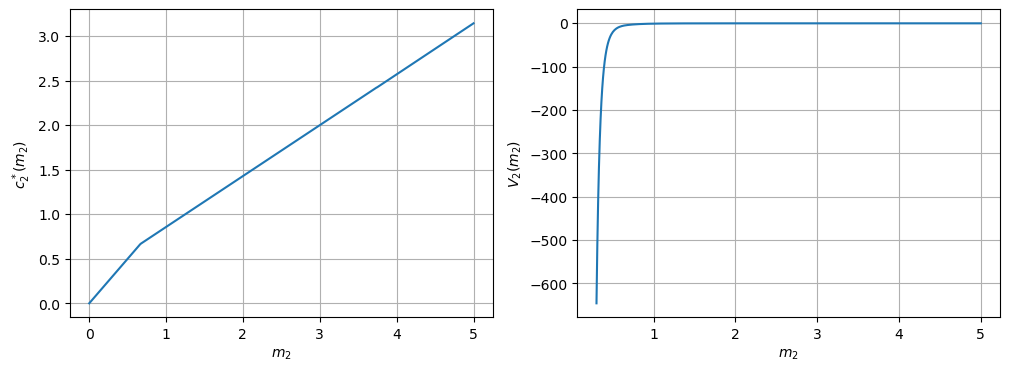

In [22]:
rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

## Step 1: solve period 2
## we can do this easily by using the solve_period_2 function - make sure you understand how it works!
m2_vec,v2_vec,c2_vec = solve_period_2(rho, nu, kappa, Delta)

## Lets see what the period 2 solution looks like
fig = plt.figure(figsize=(12,4))

ax0 = fig.add_subplot(121)
ax0.plot(m2_vec, c2_vec)
ax0.set_xlabel('$m_2$')
ax0.set_ylabel('$c_2^*(m_2)$')
ax0.grid(True)

ax1 = fig.add_subplot(122)
ax1.plot(m2_vec[30:], v2_vec[30:]) ##<----------- skipping the first 30 points to adjust the axis
ax1.set_xlabel('$m_2$')
ax1.set_ylabel('$V_2(m_2)$')
ax1.grid(True)

In [23]:
## Note the kink in the consumption function: This is due to the credit constraint. Below the kink, the consumer consumers all of m2 (credit constraint is binding). Above, he leaves a bequest.
## Note also that the value goes to -infinity as m2 (and hence consumption) approaches 0.

In [24]:
## Step 2: solve period 1
## First, we create an interpolater of period 2's value function
v2_interp = interpolate.interp1d(m2_vec, v2_vec, fill_value=True, bounds_error=None)
## fill_value=True, bounds_error=None: extrapolate when evaulating below or above grid

## v2_interp is now a function that provides us with an interpolated value for any given input m2
## That means we can evaluate the value of m2 even when m2 is not in the m2_grid:
for m2 in [0.5, 1.0, 2.5, 3.7]:
    print(f'\n{m2} in m2_vec? {m2 in m2_vec}')
    print(f'v2({m2}) = {v2_interp(m2) :7.5f}')


0.5 in m2_vec? False
v2(0.5) = -20.13372

1.0 in m2_vec? False
v2(1.0) = -0.73527

2.5 in m2_vec? False
v2(2.5) = -0.00574

3.7 in m2_vec? False
v2(3.7) = -0.00054


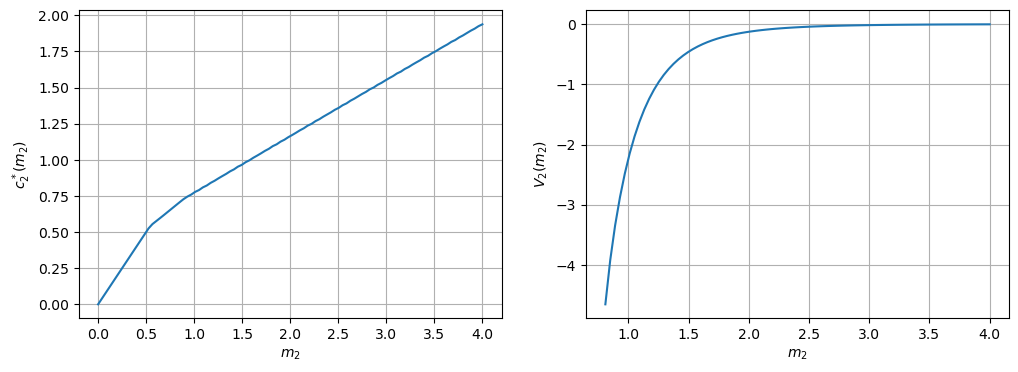

In [25]:
## Next, we use the v2 interpolater to solve period 1
m1_vec,v1_vec,c1_vec = solve_period_1(rho, beta, r, Delta, v1, v2_interp)

fig = plt.figure(figsize=(12,4))

ax0 = fig.add_subplot(121)
ax0.plot(m1_vec, c1_vec)
ax0.set_xlabel('$m_2$')
ax0.set_ylabel('$c_2^*(m_2)$')
ax0.grid(True)

ax1 = fig.add_subplot(122)
ax1.plot(m1_vec[20:], v1_vec[20:]) 
ax1.set_xlabel('$m_2$')
ax1.set_ylabel('$V_2(m_2)$')
ax1.grid(True)

In [26]:
## In period 1 there are several kinks in the consumption function:  where the credit constraint kicks in today, and also where it might kick in tomorrow. 

**Answer:** A11.py

**Question B:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it, assuming that

$$ 
y_{2} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}
$$

which add some low probability tail events, but does not change mean income. Give an interpretation of the change in the consumption function.

In [27]:
## We don't need to re-solve period 2. This is because GIVEN m2, the solution to the two versions of
## the problem are the same.

## But we do have to solve period 1 again, because this change affects the expected value given the
## information available in period 1.

## The new value function in period 1 is now:
def v1_alt(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value if very low
    m2_vlow = (1+r)*(m1-c1) + 1-Delta**0.5
    v2_vlow = v2_interp([m2_vlow])[0]

    # b. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # c. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]

    # d. v2 value if very high income
    m2_vhigh = (1+r)*(m1-c1) + 1+Delta**0.5
    v2_vhigh = v2_interp([m2_high])[0]
    
    # e. expected v2 value
    v2 = 0.1*v2_vlow + 0.4*v2_low + 0.4*v2_high + 0.1*v2_vhigh
    
    # f. total value
    return utility(c1,rho) + beta*v2

## so we re-solve period 1
m1_vec_alt,v1_vec_alt,c1_vec_alt = solve_period_1(rho, beta, r, Delta, v1_alt, v2_interp)


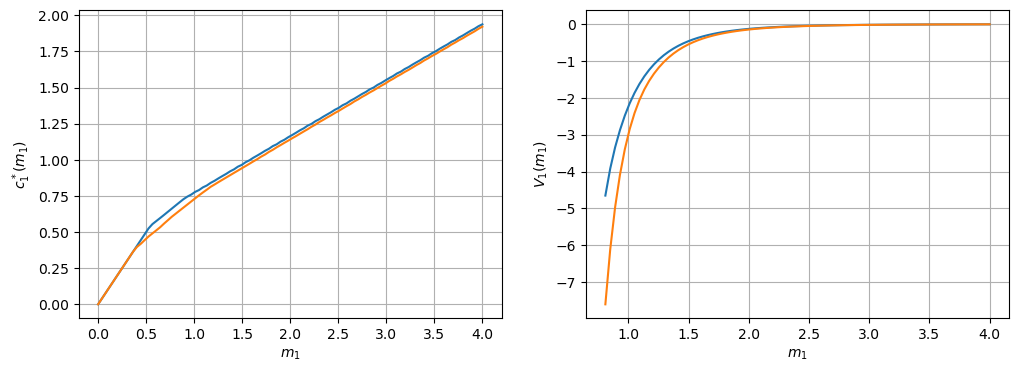

In [28]:
## Let's plot the two model solutions
fig = plt.figure(figsize=(12,4))

ax0 = fig.add_subplot(121)
ax0.plot(m1_vec, c1_vec, label='Standard model')
ax0.plot(m1_vec_alt, c1_vec_alt, label='High risk model')
ax0.set_xlabel('$m_1$')
ax0.set_ylabel('$c_1^*(m_1)$')
ax0.grid(True)

ax1 = fig.add_subplot(122)
ax1.plot(m1_vec[20:], v1_vec[20:], label='Standard model') 
ax1.plot(m1_vec_alt[20:], v1_vec_alt[20:], label='High risk model')
ax1.set_xlabel('$m_1$')
ax1.set_ylabel('$V_1(m_1)$')
ax1.grid(True)

In [29]:
## Take-aways:
## Consumption for any given level of m2 is lower in the high risk model -> the consumer saves to insure against bad income shock (precautionary saving).
## The section where the consumer consumes all of his assets is smaller (credit constraint is less binding)
## For any given level of m2, the value is lower -> the consumer is risk averse.

**Answer:** A12.py

# Problem: Solve the consumer problem with income risk II

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

Choose **parameters**:

In [30]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

The **basic functions** are:

In [31]:
def utility(c,d,alpha,rho):
    return c**(1-rho)/(1-rho) + alpha*d**(1-rho)/(1-rho)

def bequest(m,c,d,nu,kappa,rho):
    return nu*(m+d-c+kappa)**(1-rho)/(1-rho)

def v2(c2,d2,m2,alpha,rho,nu,kappa):
    return utility(c2,d2,alpha,rho) + bequest(m2,c2,d2,nu,kappa,rho)

def v1(c1,d1,m1,alpha,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1-d1) + 1-Delta
    v2_low = v2_interp([m2_low,d1])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1-d1) + 1+Delta
    v2_high = v2_interp([m2_high,d1])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,d1,alpha,rho) + beta*v2

The **solution function for period 2** is:

In [32]:
def solve_period_2(alpha,rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,200)
    d2_vec = np.linspace(1e-6,5,100)
    v2_grid = np.empty((200,100))
    c2_grid = np.empty((200,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda x: -v2(x[0],d2,m2,alpha,rho,nu,kappa)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x[0]
        
    return m2_vec,d2_vec,v2_grid,c2_grid

**Question A:** Solve for consumption in period 2 and plot the consumption function.

In [33]:
## In period 2, we now have TWO state variables: m2 (cash on hand) and d2 (durable consumption good)
## So the solution takes quite a bit longer, since we now have to loop over a two dimensional grid
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha, rho, nu, kappa, Delta)

Text(0.5, 0.5, '$d_2$')

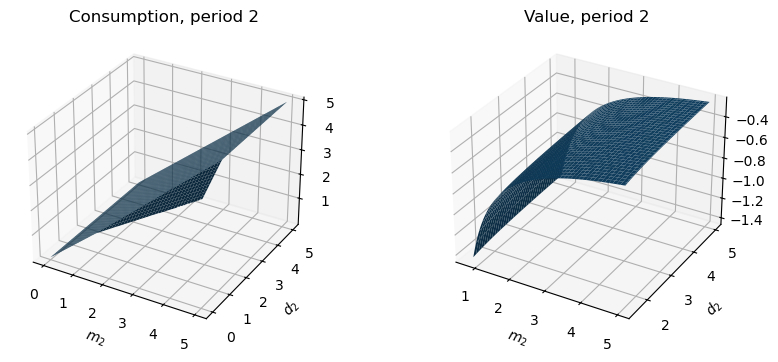

In [34]:
fig = plt.figure(figsize=(10,4))

m2_mesh, d2_mesh = np.meshgrid(m2_vec, d2_vec, indexing='ij')

ax0 = fig.add_subplot(121, projection='3d')
ax0.plot_surface(m2_mesh, d2_mesh, c2_grid)
ax0.set_title('Consumption, period 2')
ax0.set_xlabel('$m_2$')
ax0.set_ylabel('$d_2$')

ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(m2_mesh[30:,30:], d2_mesh[30:,30:], v2_grid[30:,30:])
ax1.set_title('Value, period 2')
ax1.set_xlabel('$m_2$')
ax1.set_ylabel('$d_2$')

**Answer:** A13.py

**Question B:** Find optimal consumption and choices of durables in the first period as a function of cash-on-hand and plot it.

In [35]:
## We need to define the solution function for period 1 ourselves this time
def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-4,5,100)
    
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    d1_vec = np.empty(100) ##<----------------- d1 is a choice in period 1 - so we need a policy function for it
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],x[1],m1,alpha,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume 1/2 on consumption, 1/4 on durables)
        x0 = np.array([m1/2, m1/4])
                
        # iii. optimize
        result = optimize.minimize(obj,x0,method='SLSQP',bounds=((1e-8,m1),(1e-8,m1)),
                                   constraints={'type':'ineq', 'fun': lambda x: m1 - x[0] - x[1]})
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
        d1_vec[i] = result.x[1]
     
    return m1_vec,v1_vec,c1_vec, d1_vec

## Now we need to construct a two dimensional interpolater of v2
v2_interp = interpolate.RegularGridInterpolator((m2_vec, d2_vec), v2_grid, fill_value=True, bounds_error=None)

## solve period 1
m1_vec, v2_vec, c1_vec, d1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)


c:\ProgramData\Anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Text(0.5, 1.0, 'Value, period 1')

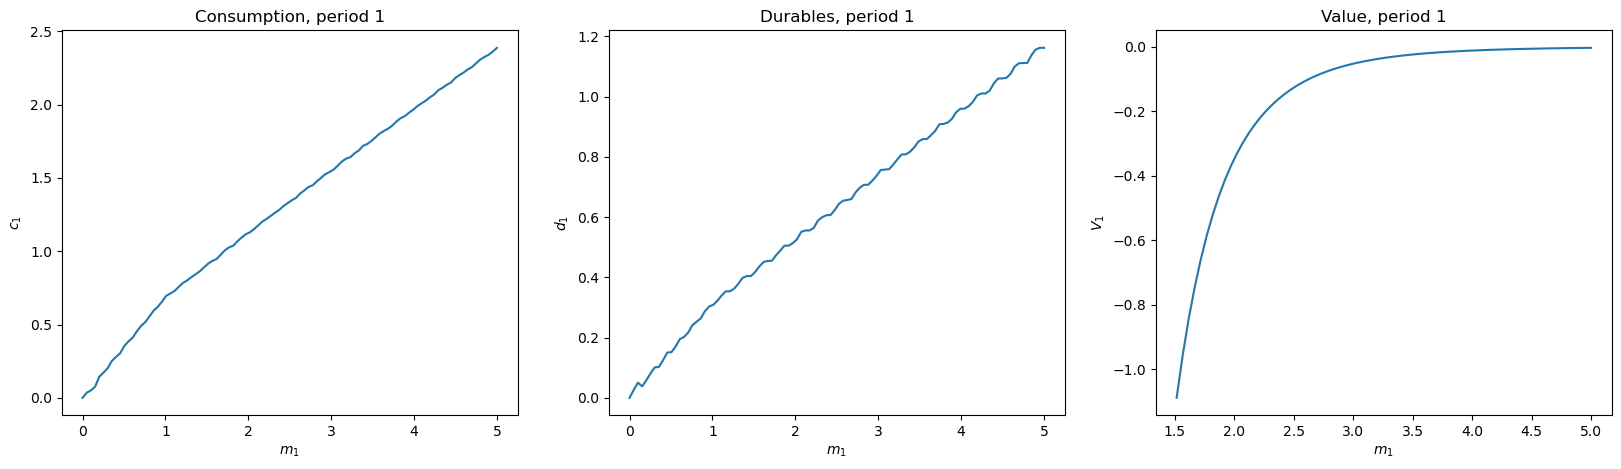

In [36]:
## plot solutions 
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(131)
ax0.plot(m1_vec, c1_vec)
ax0.set_xlabel('$m_1$')
ax0.set_ylabel('$c_1$')
ax0.set_title('Consumption, period 1')

ax1 = fig.add_subplot(132)
ax1.plot(m1_vec, d1_vec)
ax1.set_xlabel('$m_1$')
ax1.set_ylabel('$d_1$')
ax1.set_title('Durables, period 1')

ax2 = fig.add_subplot(133)
ax2.plot(m1_vec[30:], v1_vec[30:])
ax2.set_xlabel('$m_1$')
ax2.set_ylabel('$V_1$')
ax2.set_title('Value, period 1')

In [37]:
## Functions are a little jumpy due to numerical error - but ok to an approximation

**Answer:** A14.py

# Extra Problems

**Simulate** a distribution of consumers in either of the two consumption-saving models above. See **section 6.3 in lecture 11** regarding 
how this is done.

In [38]:
## Let's simulate from the durable-consumption model
def simulate(N, c1_interp, d1_interp, c2_interp, r, Delta, seed):

    # a. set seed
    np.random.seed(seed)
    
    # b. containers for solution
    c1 = np.empty(N)
    c2 = np.empty(N)
    d = np.empty(N)
    
    # c. initial state - I draw from a random uniform distribution
    m1 = np.random.uniform(1,3,N)
    
    # d. container for state in period 2
    m2 = np.empty(N)

    # e. draw random income in period 2
    y2 = np.random.choice([1-Delta,1+Delta], p=[0.5,0.5],size=N)
    
    # f. construct interpolaters for solution function
    c1_interp = interpolate.interp1d(m1_vec, c1_vec, fill_value=True, bounds_error=None)
    d1_interp = interpolate.interp1d(m1_vec, d1_vec, fill_value=True, bounds_error=None)
    c2_interp = interpolate.RegularGridInterpolator((m2_vec, d2_vec), c2_grid, fill_value=True, bounds_error=None)
    
    # g. simulate
    for i in range(N):
        
        # i. get state
        m1_i = m1[i]
        
        # ii. interpolate optimal choice in period 1
        c1[i] = c1_interp(m1_i)
        d[i] = d1_interp(m1_i)
        
        # iii. find period 2 state 
        d_i = d[i]
        m2_i = (1+r)*(m1_i - c1[i] - d[i]) + y2[i]
        m2[i] = m2_i
        
        # iv. interpolate optimal choice in period 2
        c2[i] = c2_interp([m2_i, d[i]])
        
    return c1, c2, d, y2, m1, m2


## Construct interpolators of policy functions
c1_interp = interpolate.interp1d(m1_vec, c1_vec, fill_value=True, bounds_error=None)
d1_interp = interpolate.interp1d(m1_vec, d1_vec, fill_value=True, bounds_error=None)
c2_interp = interpolate.RegularGridInterpolator((m2_vec, d2_vec), c2_grid, fill_value=True, bounds_error=None)

## Simulate
c1_sim, c2_sim, d_sim, y2_sim, m1_sim, m2_sim = simulate(1000, c1_interp, d1_interp, c2_interp, r, Delta, 2106)

C:\Users\jmh520\AppData\Local\Temp\ipykernel_17428\1458668578.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c2[i] = c2_interp([m2_i, d[i]])


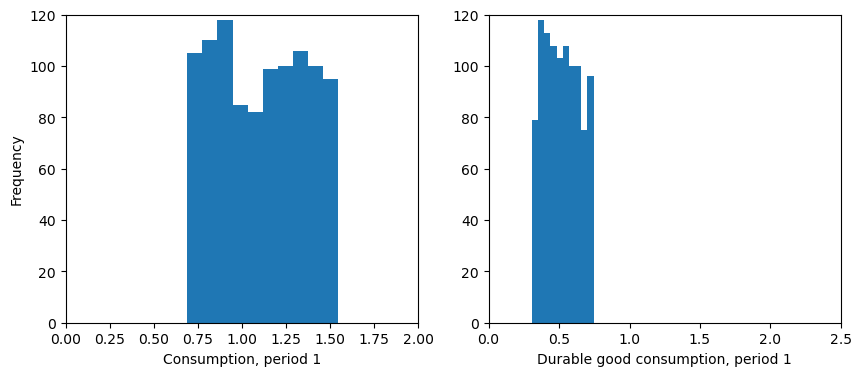

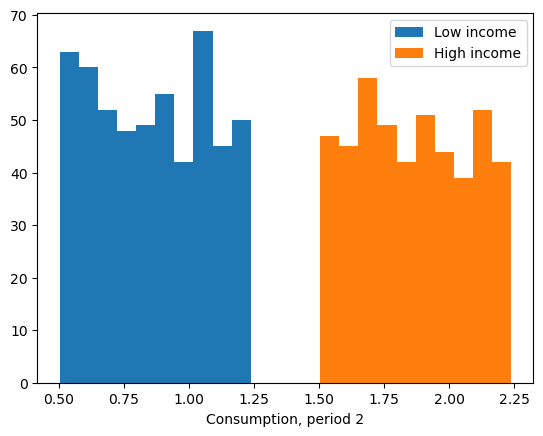

In [39]:
## we can use the simulation to explore the results!

# period 1
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.hist(c1_sim)
ax.set_ylabel('Frequency')
ax.set_xlabel('Consumption, period 1')
ax.set_ylim(0,120)
ax.set_xlim(0, 2)

ax = fig.add_subplot(1,2,2)
ax.hist(d_sim)
ax.set_xlabel('Durable good consumption, period 1')
ax.set_ylim(0,120)
ax.set_xlim(0, 2.5)

# period 2
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(c2_sim[y2_sim==0.5], label='Low income')
ax.hist(c2_sim[y2_sim==1.5], label='High income')
ax.set_xlabel('Consumption, period 2')
ax.legend();